In [1]:
using POMDPs, QuickPOMDPs, POMDPModelTools, POMDPPolicies, Parameters, Random, Plots, LinearAlgebra, Serialization
using POMDPTools, BasicPOMCP, GridInterpolations, POMCPOW, POMDPModels, Combinatorics, Dates, CSV, ParticleFilters, StatsBase

## Parameters

In [40]:
beta_vals = [0.01, 1.0]
args = [3 3 0.9 6 6 100 1000 1217]
;

## Create POMDP

In [3]:
@with_kw struct MyParameters
    N::Int = convert(Int64, args[1])         # size of item set
    K::Int = convert(Int64, args[2])         # size of arm set
    M::Int = length(beta_vals)               # size of beta set
    y::Float64 = args[3]                     # discount factor
    umax::Real = 10                          # max utility
    u_grain::Int = convert(Int64, args[4])   # granularity of utility approximation
    d_grain::Int = convert(Int64, args[5])   # granularity of arm distribution approximation
    beta::Array{Float64} = beta_vals         # teacher beta values
    exp_iters::Int = convert(Int64, args[6]) # number of rollouts to run
    exp_steps::Int = convert(Int64, args[7]) # number of timesteps per rollout
    s_index::Int = convert(Int64, args[8])   # index of true state
end

MyParameters

In [41]:
params = MyParameters()

struct State
    u::Array{Float64}         # list of N utility values for N items
    d::Array{Array{Float64}}  # list of K arm distributions, each assigning probabilities to N items
    b::Array{Float64}         # list of M beta values
end

# space of utility functions
umin = 0
grid_coor = fill(range(umin, params.umax, length=params.u_grain), params.N)
U = RectangleGrid(grid_coor...)

@assert length(U[1]) == params.N
println("generated " * string(length(U)) * " utilities (each length " * string(length(U[1])) * " items)")

function generate_probability_distributions(N::Int, coor::Array{Float64}, S::Float64=1.0)
    if S == 0
        return [[0.0 for _ in 1:N]]
    end
    if N == 1
        return [[float(S)]]
    end
    out = []
    range = coor[1:findall(x -> isapprox(x, S, atol=1e-15), coor)[1]]
    for k in range
        subsolution = generate_probability_distributions(N - 1, coor, S - k)
        for lst in subsolution
            if typeof(lst[1]) != Float64
                println("ERROR: lst " * string(lst) * " has type " * string(typeof(lst[1])) * ". Must be Float64.")
            end
            prepend!(lst, float(k))
        end
        out = vcat(out, subsolution)
    end
    return out
end

# space of arm distributions
coor = collect(range(0.0, 1.0, length=params.d_grain))
simplex_list = generate_probability_distributions(params.N, coor)
D_tuples = vec(collect(Base.product(fill(simplex_list, params.K)...)))
D = [collect(d) for d in D_tuples]

@assert length(D[1]) == params.K
@assert length(D[1][1]) == params.N
println("generated " * string(length(D)) * " arm distribution sets (each shape " * string(length(D[1])) * " arms x " * string(length(D[1][1])) * " items)")

# beta values
B = [params.beta]

# each beta value set must be length M
@assert length(B[1]) == params.M
println("generated " * string(length(B)) * " beta value sets (each length " * string(length(B[1])) * " teachers)")

# State space
S = [[State(u, d, b) for u in U, d in D, b in B]...,]

println("generated " * string(length(S)) * " states")

# Action space - actions are arm choices (K) or beta selections (M)
struct Action
    name::String      # valid names are {B,C} + index
    isBeta::Bool      # true if 'B' action, false if 'C' action
    index::Integer    # index of beta (if 'B' action) or arm choice (if 'C' action)
end

A = Array{Action}(undef, params.K + params.M)
for i in 1:params.K+params.M
    if i <= params.K
        A[i] = Action("C" * string(i), false, i)
    else
        A[i] = Action("B" * string(i - params.K), true, i - params.K)
    end
end
println("generated " * string(length(A)) * " actions")

# Transition function
function T(s::State, a::Action)
    return SparseCat([s], [1.0])    # categorical distribution
end
println("generated transition function")

# Reward function
function R(s::State, a::Action)
    # if beta selected, return 0
    if a.isBeta
        return 0
        # if arm pulled, return that arm's avg utility
    else
        utilities = s.u
        arm_dist = s.d[a.index]
        return dot(utilities, arm_dist)
    end
end
println("generated reward function")

# item space
I = 1:params.N

# preference space
struct Preference
    i0::Int    # first item to compare, in {1,2,...,N}
    i1::Int    # second item to compare, in {1,2,...,N}
    label::Int # feedback label, in {0,1}
end

P = [[Preference(i0, i1, label) for i0 in I, i1 in I, label in [0, 1]]...,]

# observation space
struct Observation
    isItem::Bool    # true if item returned, false otherwise
    i::Int          # item, if item returned
    p::Preference   # preference, if preference returned
end

invalid_i = -1
invalid_p = Preference(-1, -1, -1)
I_obs = [Observation(true, i, invalid_p) for i in I]
P_obs = [Observation(false, invalid_i, p) for p in P]
omega = union(I_obs, P_obs)

println("generated " * string(length(omega)) * " observations")

# unnormalized query profile (likelihood of querying 1,1; 2,1; 3,1; ... ; N,1; 1,2; 2,2; ... ; N,N)
Q = ones(params.N * params.N)

# preference probability (expected preference, or probability that preference=1)
function Pr(p::Preference, s::State, b::Float64)
    prob_pref_1 = exp(Float64(b) * s.u[p.i1]) / (exp(Float64(b) * s.u[p.i1]) + exp(Float64(b) * s.u[p.i0]))
    if p.label == 1
        return prob_pref_1
    else
        return 1.0 - prob_pref_1
    end
end

function O(s::State, a::Action, sp::State)
    # if B action, obs in P_obs
    if a.isBeta
        prob_of_pref = [Pr(o.p, s, s.b[a.index]) for o in P_obs]
        prob_of_query = vcat(Q, Q)   # doubled because each query appears once for each label

        # weight by querying profile to get dist
        dist = [prob_of_pref[i] * prob_of_query[i] for i in 1:length(prob_of_pref)]
        normalized_dist = dist / sum(dist)
        return SparseCat(P_obs, normalized_dist)
        # if C action, obs in I_obs
    else
        return SparseCat(I_obs, s.d[a.index])
    end
end

println("generated observation function")

# define POMDP
abstract type MyPOMDP <: POMDP{State,Action,Observation} end
pomdp = QuickPOMDP(MyPOMDP,
    states=S,
    actions=A,
    observations=omega,
    transition=T,
    observation=O,
    reward=R,
    discount=params.y,
    initialstate=S);

println("created POMDP")

generated 216 utilities (each length 3 items)
generated 9261 arm distribution sets (each shape 3 arms x 3 items)
generated 1 beta value sets (each length 2 teachers)
generated 2000376 states
generated 5 actions
generated transition function
generated reward function
generated 21 observations
generated observation function
created POMDP


## Generate Random Rollout

In [42]:
prior = Uniform(S)
true_state = S[params.s_index]
println("true state:\n"*string(true_state))

true state:
State([8.0, 8.0, 6.0], Array{Float64}[[0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0]], [0.01, 1.0])


In [43]:
obs = Dict{Int, Array{Observation}}()
act = Dict{Int, Array{Action}}()
for run in 1:params.exp_iters
    sim = RolloutSimulator(max_steps=params.exp_steps)
    a = Array{Action}(undef, params.exp_steps)
    o = Array{Observation}(undef, params.exp_steps)
    r = zeros(params.exp_steps)
    t = collect(1:params.exp_steps)

    policy = RandomPolicy(pomdp)
    i = 1
    for (st, ac, ob, re) in stepthrough(pomdp, policy, updater(policy), prior, true_state, "s,a,o,r", max_steps=params.exp_steps)
        a[i] = ac
        o[i] = ob
        r[i] = re
        i = i+1
    end

    obs[run] = o
    act[run] = a
end        
        
        

## Infer Beta Values

In [44]:
# Which is the most numerous teacher query?
function get_query(o::Observation)
    if o.isItem
        return (-1,-1)
    end
    p = o.p
    i0 = p.i0
    i1 = p.i1
    if i0 < i1
        return (i0,i1)
    end
    return (i1,i0)
end

function infer_beta_vals(o, a)
    query_dict = Dict{Tuple{Int,Int}, Int}()
    for ob in o
        key = get_query(ob)
        if key[1] == -1
            continue
        end
        if key in keys(query_dict)
            query_dict[key] = query_dict[key]+1
        else
            query_dict[key] = 1
        end
    end

    max_key = -1
    max_val = -1
    for key in keys(query_dict)
        if query_dict[key] > max_val
            max_val = query_dict[key]
            max_key = key
        end
    end

    # Which preferences over the most common query come from which teacher?
    pref_dict = Dict{Action, Array{Preference}}()
    i0_pref = 0
    i1_pref = 0
    for i in 1:length(a)
        if !a[i].isBeta
            continue
        end
        q = get_query(o[i])
        if q != max_key
            continue
        end

        if o[i].p.i0 == max_key[1] && o[i].p.label == 0
            i0_pref = i0_pref+1
        elseif o[i].p.i1 == max_key[1] && o[i].p.label == 1
            i0_pref = i0_pref+1
        else
            i1_pref = i1_pref+1
        end

        if a[i] in keys(pref_dict)
            push!(pref_dict[a[i]], o[i].p)
        else
            pref_dict[a[i]] = [o[i].p]
        end
    end

    # Calc how often each teacher chooses better item
    P = Dict{Action, Float64}()
    epsilon = 0.001
    if i0_pref > i1_pref
        better_i = max_key[1]
    else
        better_i = max_key[2]
    end

    for teach in keys(pref_dict)
        better_i_pref = 0
        worse_i_pref = 0
        for p in pref_dict[teach]
            if p.i0 == better_i && p.label == 0
                better_i_pref = better_i_pref+1
            elseif p.i1 == better_i && p.label == 1
                better_i_pref = better_i_pref+1
            else
                worse_i_pref = worse_i_pref+1
            end
        end
        if worse_i_pref == 0
            println("WARNING: teacher "*string(teach.name)*" didn't ever choose worse item (approximating with epsilon)")
            P[teach] = epsilon/(better_i_pref+worse_i_pref)
        else
            P[teach] = worse_i_pref/(better_i_pref+worse_i_pref)
        end
    end
    betas = [log((1/P[key])-1) for key in keys(P)]
    return betas
end

infer_beta_vals (generic function with 1 method)

In [45]:
betas = Dict{Int, Array{Float64}}()
for run in 1:params.exp_iters
    beta = infer_beta_vals(obs[run], act[run])
    betas[run] = beta

end


In [46]:
# rescale max beta estimate to true max beta value
scalars = Dict{Int, Float64}()
for run in 1:params.exp_iters
    scalar = maximum(beta_vals)/maximum(betas[run])

#     if step ∉ keys(scalars)
#         scalars[step] = Dict{Int, Float64}()
#     end
    scalars[run] = scalar
end


In [47]:
rescaled_betas = Dict{Int, Array{Float64}}()

for run in 1:params.exp_iters
    rescaled_beta = scalars[run]*betas[run]

#     if step ∉ keys(rescaled_betas)
#         rescaled_betas = Dict{Int, Array{Float64}}()
#     end
    rescaled_betas[run] = rescaled_beta

end


In [54]:
rescaled_betas

Dict{Int64, Array{Float64}} with 100 entries:
  5  => [1.0, -0.0566729]
  56 => [1.0, 0.141192]
  35 => [1.0, 0.0465362]
  55 => [1.0, 0.185522]
  60 => [0.230764, 1.0]
  30 => [1.0, 0.0936947]
  32 => [1.0, 0.0]
  6  => [1.0, 0.0997913]
  67 => [1.0, 0.50812]
  45 => [-0.267529, 1.0]
  73 => [1.0, -0.465394]
  64 => [1.0, 0.118474]
  90 => [1.0, -0.496999]
  4  => [1.0, -0.986299]
  13 => [-0.39188, 1.0]
  54 => [1.0, -0.301015]
  63 => [1.0, 0.186066]
  86 => [1.0, -0.0247143]
  91 => [1.0, 0.0266901]
  62 => [1.0, 0.425949]
  58 => [1.0, 0.0]
  52 => [1.0, 0.236001]
  12 => [1.0, -0.0730498]
  28 => [1.0, 0.0198024]
  75 => [1.0, -0.346738]
  ⋮  => ⋮

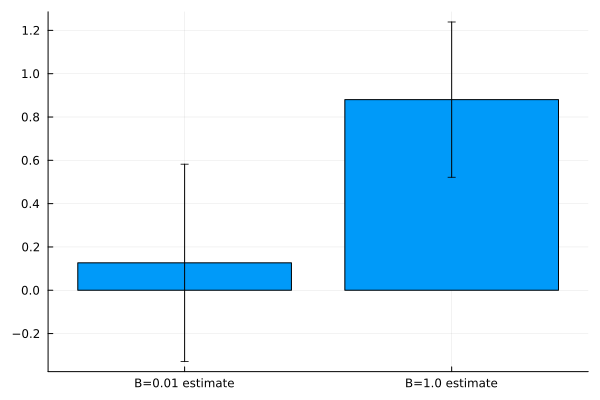

In [56]:
f1 = [rescaled_betas[k][1] for k in keys(rescaled_betas)]
f2 = [rescaled_betas[k][2] for k in keys(rescaled_betas)]
bar(["B=0.01 estimate", "B=1.0 estimate"], [mean(f2), mean(f1)], yerr=[std(f2), std(f1)], legend=false)

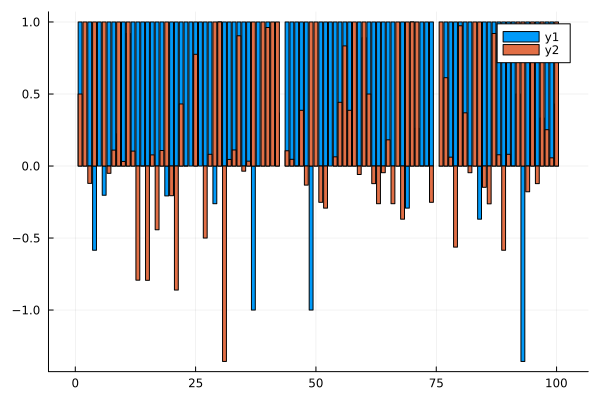

In [18]:
rescaled_betas
bar([[rescaled_betas[k][1] for k in keys(rescaled_betas)], [rescaled_betas[k][2] for k in keys(rescaled_betas)]])



In [13]:
# calculate MSE for each run
MSD = Dict{Int, Float64}()
for run in 1:params.exp_iters
    b = rescaled_betas[run]

    # order them with smaller first
    comparison = b[1] < b[2] ? [b[1], b[2]] : [b[2], b[1]]

    if size(comparison) != size(beta_vals)
        print(size(comparison))
        print(size(beta_vals))
    end
    error = msd(comparison, beta_vals)
#         println("\nerror between")
#         println(b, " and")
#         println(beta_vals, "\t\t= ", error)

#         if step ∉ keys(MSD)
#             MSD[step] = Dict{Int, Float64}()
#         end
    MSD[run] = error
        
end

In [14]:
# average MSE across runs
MSDs = []
for run in 1:params.exp_iters
    push!(MSDs, MSD[run])
end
avg_MSD = mean(MSDs)
avg_MSD

NaN

In [15]:
# plot MSE against steps
# plot(steps, avg_MSD)